# Module 1.9: Gaps, Outliers, and Duplicates Treatment

> **Goal:** Detect and treat gaps, duplicates, and outliers without lying to the model — and enforce a clean **weekly granularity** for the target.

In previous modules, we:
- Explored the M5 dataset and its structure (sales, calendar, prices)
- Built a clean, Nixtla-friendly schema: `unique_id`, `ds`, `y`
- Joined calendar & prices safely, avoiding look-ahead

In this module, we:
1. Convert the daily target to **weekly** granularity (the course will forecast weekly sales)
2. Detect and handle **duplicates** — learn when to drop vs aggregate
3. Enforce **regular time sequences** using Nixtla's `fill_gaps`
4. Detect **outliers** using multiple methods — learn when to use IQR vs Z-score vs MAD
5. Apply transparent **imputation policies** with proper flagging

The output is a clean weekly target table that downstream models can trust.

---

## 1. Setup & Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tsforge as tsf
# Nixtla utilities
from utilsforecast.preprocessing import fill_gaps

# Configuration
pd.set_option("display.max_rows", 10)
pd.set_option("display.width", 120)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Paths
DATA_DIR = Path('./data')
OUTPUT_DIR = Path('./output')
OUTPUT_DIR.mkdir(exist_ok=True)

print("✓ Setup complete")

✓ Setup complete


## 2. Load the Clean Daily Target

We start from the cleaned daily data produced in Module 1.8. This should already:
- Be in **long** format (`unique_id`, `ds`, `y`)
- Have corrected obvious schema issues
- Be safely joined with any calendar/price features

In [2]:
# Load from prior module
daily_path = OUTPUT_DIR / "m5_clean.parquet"

y_daily = pd.read_parquet(daily_path)

# Ensure correct dtypes
y_daily["ds"] = pd.to_datetime(y_daily["ds"])
y_daily["y"] = pd.to_numeric(y_daily["y"], errors="coerce")

print(f"Loaded daily data: {len(y_daily):,} rows")
print(f"Date range: {y_daily['ds'].min().date()} to {y_daily['ds'].max().date()}")
print(f"Unique series: {y_daily['unique_id'].nunique():,}")
y_daily.head()

Loaded daily data: 47,649,940 rows
Date range: 2011-01-29 to 2016-06-19
Unique series: 30,490


,unique_id,ds,y,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,wm_yr_wk,sell_price_lag7
0,FOODS_1_001_CA_1,2011-01-29,3.0,1,1,2011,None,None,0,0,0,11101,NaN
1,FOODS_1_001_CA_1,2011-01-30,0.0,2,1,2011,None,None,0,0,0,11101,NaN
2,FOODS_1_001_CA_1,2011-01-31,0.0,3,1,2011,None,None,0,0,0,11101,NaN
3,FOODS_1_001_CA_1,2011-02-01,1.0,4,2,2011,None,None,1,1,0,11101,NaN
4,FOODS_1_001_CA_1,2011-02-02,4.0,5,2,2011,None,None,1,0,1,11101,NaN


## 3. Aggregate to Weekly Granularity

### 3.1 Why Weekly?

This course forecasts **weekly** sales, not daily. Weekly granularity:
- Reduces noise from day-to-day volatility
- Aligns with business planning cycles
- Naturally handles day-of-week effects
- Reduces intermittency (fewer zero periods)

### 3.2 M5 Week Alignment

For M5:
- The first day (`d_1`) is **2011-01-29**, a **Saturday**
- The `wm_yr_wk` field in `calendar.csv` increments weekly from that Saturday
- We use `freq="W-SAT"` to align with M5's week definition

### 3.3 Aggregation Policies by Variable Type

Our daily data includes multiple columns from the Module 1.8 join:

```
unique_id, ds, y, wday, month, year, event_name_1, event_type_1, 
snap_CA, snap_TX, snap_WI, wm_yr_wk, sell_price_lag7
```

When aggregating to weekly, **different variables require different policies**:

#### The Aggregation Policy Matrix

| Variable | Type | Aggregation | Rationale |
|----------|------|-------------|----------|
| `y` | Target (count) | **SUM** | Total demand for the week |
| `wday` | Categorical | **DROP** | Not meaningful at weekly level |
| `month`, `year` | Time features | **FIRST** | Constant within week (or use week-end date) |
| `event_name_1`, `event_type_1` | Categorical | **FIRST** or **MODE** | Keep dominant event, or create event count |
| `snap_CA`, `snap_TX`, `snap_WI` | Binary | **MAX** or **SUM** | Any SNAP day? Or count of SNAP days? |
| `wm_yr_wk` | Week ID | **FIRST** | Already weekly — should be constant |
| `sell_price_lag7` | Price | **FIRST** | Already weekly in M5 — should be constant |

---

#### Binary Event Flags: MAX vs SUM

For binary indicators (SNAP, holiday), you have two choices:

| Method | Result | Use When |
|--------|--------|----------|
| **MAX** | 1 if event on *any* day | You care about "did it happen this week?" |
| **SUM** | Count of event days (0-7) | You care about "how many days of exposure?" |

**Example: SNAP eligibility**
- SNAP benefits are distributed on specific days of the month
- A week might have 0, 1, 2, or 3 SNAP days
- `MAX` → "Was there SNAP activity this week?" (binary)
- `SUM` → "How many SNAP days this week?" (intensity)

**Our choice:** Use `MAX` for simplicity — captures whether the week had any SNAP/event exposure.

---

#### Summary: Aggregation Decision Tree

```
What type of variable?
│
├── TARGET (y - units sold)
│   └── SUM (preserve total demand)
│
├── BINARY EVENT (snap_*, event flags)
│   └── MAX (any occurrence) or SUM (count days)
│
├── ALREADY WEEKLY (wm_yr_wk, sell_price_lag7)
│   └── FIRST (should be constant within week)
│
├── TIME FEATURES (month, year)
│   └── FIRST (use week-ending values)
│
└── DAILY-SPECIFIC (wday)
    └── DROP (not meaningful at weekly level)
```

### 3.4 Apply Weekly Aggregation

In [3]:
# Check what columns we have
print("Columns in daily data:")
print(y_daily.columns.tolist())
print(f"\nShape: {y_daily.shape}")

Columns in daily data:
['unique_id', 'ds', 'y', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI', 'wm_yr_wk', 'sell_price_lag7']

Shape: (47649940, 13)


In [4]:
# Step 1: Create week-ending date column (more memory efficient than pd.Grouper)
y_daily['ds'] = pd.to_datetime(y_daily['ds'])

# Calculate week-ending Saturday
# dayofweek: Monday=0, Saturday=5
# We want to shift each date to its week-ending Saturday
y_daily['week_end'] = y_daily['ds'] + pd.to_timedelta((5 - y_daily['ds'].dt.dayofweek) % 7, unit='D')

print(f"Sample date mapping:")
print(y_daily[['ds', 'week_end']].drop_duplicates().head(10))

Sample date mapping:
          ds   week_end
0 2011-01-29 2011-01-29
1 2011-01-30 2011-02-05
2 2011-01-31 2011-02-05
3 2011-02-01 2011-02-05
4 2011-02-02 2011-02-05
5 2011-02-03 2011-02-05
6 2011-02-04 2011-02-05
7 2011-02-05 2011-02-05
8 2011-02-06 2011-02-12
9 2011-02-07 2011-02-12


In [ ]:
# Step 2: Define aggregation policies
# Build aggregation dict based on available columns

agg_dict = {'y': 'sum'}  # Target: always sum

print("Aggregation policies:")
for col, policy in agg_dict.items():
    print(f"  {col}: {policy}")
print(f"\nDropping: wday (not meaningful at weekly level)")

Aggregation policies:
  y: sum
  snap_CA: max
  snap_TX: max
  snap_WI: max
  event_name_1: first
  event_type_1: first
  wm_yr_wk: first
  sell_price_lag7: first
  month: first
  year: first

Dropping: wday (not meaningful at weekly level)


In [6]:
# Step 3: Perform aggregation (memory-efficient approach)
print("Aggregating to weekly...")

y_weekly_raw = (
    y_daily
    .groupby(['unique_id', 'week_end'])
    .agg(agg_dict)
    .reset_index()
    .rename(columns={'week_end': 'ds'})
    .sort_values(['unique_id', 'ds'])
    .reset_index(drop=True)
)

print(f"\n✓ Aggregation complete")
print(f"  Daily rows: {len(y_daily):,}")
print(f"  Weekly rows: {len(y_weekly_raw):,}")
print(f"  Reduction: {len(y_daily) / len(y_weekly_raw):.1f}x")

y_weekly_raw.head()

Aggregating to weekly...

✓ Aggregation complete
  Daily rows: 47,649,940
  Weekly rows: 6,848,887
  Reduction: 7.0x


,unique_id,ds,y,snap_CA,snap_TX,snap_WI,event_name_1,event_type_1,wm_yr_wk,sell_price_lag7,month,year
0,FOODS_1_001_CA_1,2011-01-29,3.0,0,0,0,None,None,11101,NaN,1,2011
1,FOODS_1_001_CA_1,2011-02-05,9.0,1,1,1,None,None,11101,NaN,1,2011
2,FOODS_1_001_CA_1,2011-02-12,7.0,1,1,1,SuperBowl,Sporting,11102,2.0,2,2011
3,FOODS_1_001_CA_1,2011-02-19,8.0,0,1,1,ValentinesDay,Cultural,11103,2.0,2,2011
4,FOODS_1_001_CA_1,2011-02-26,14.0,0,0,0,PresidentsDay,National,11104,2.0,2,2011


### 3.5 Visual Comparison: Daily vs Weekly\n\nLet's see how weekly aggregation reduces noise while preserving the signal.

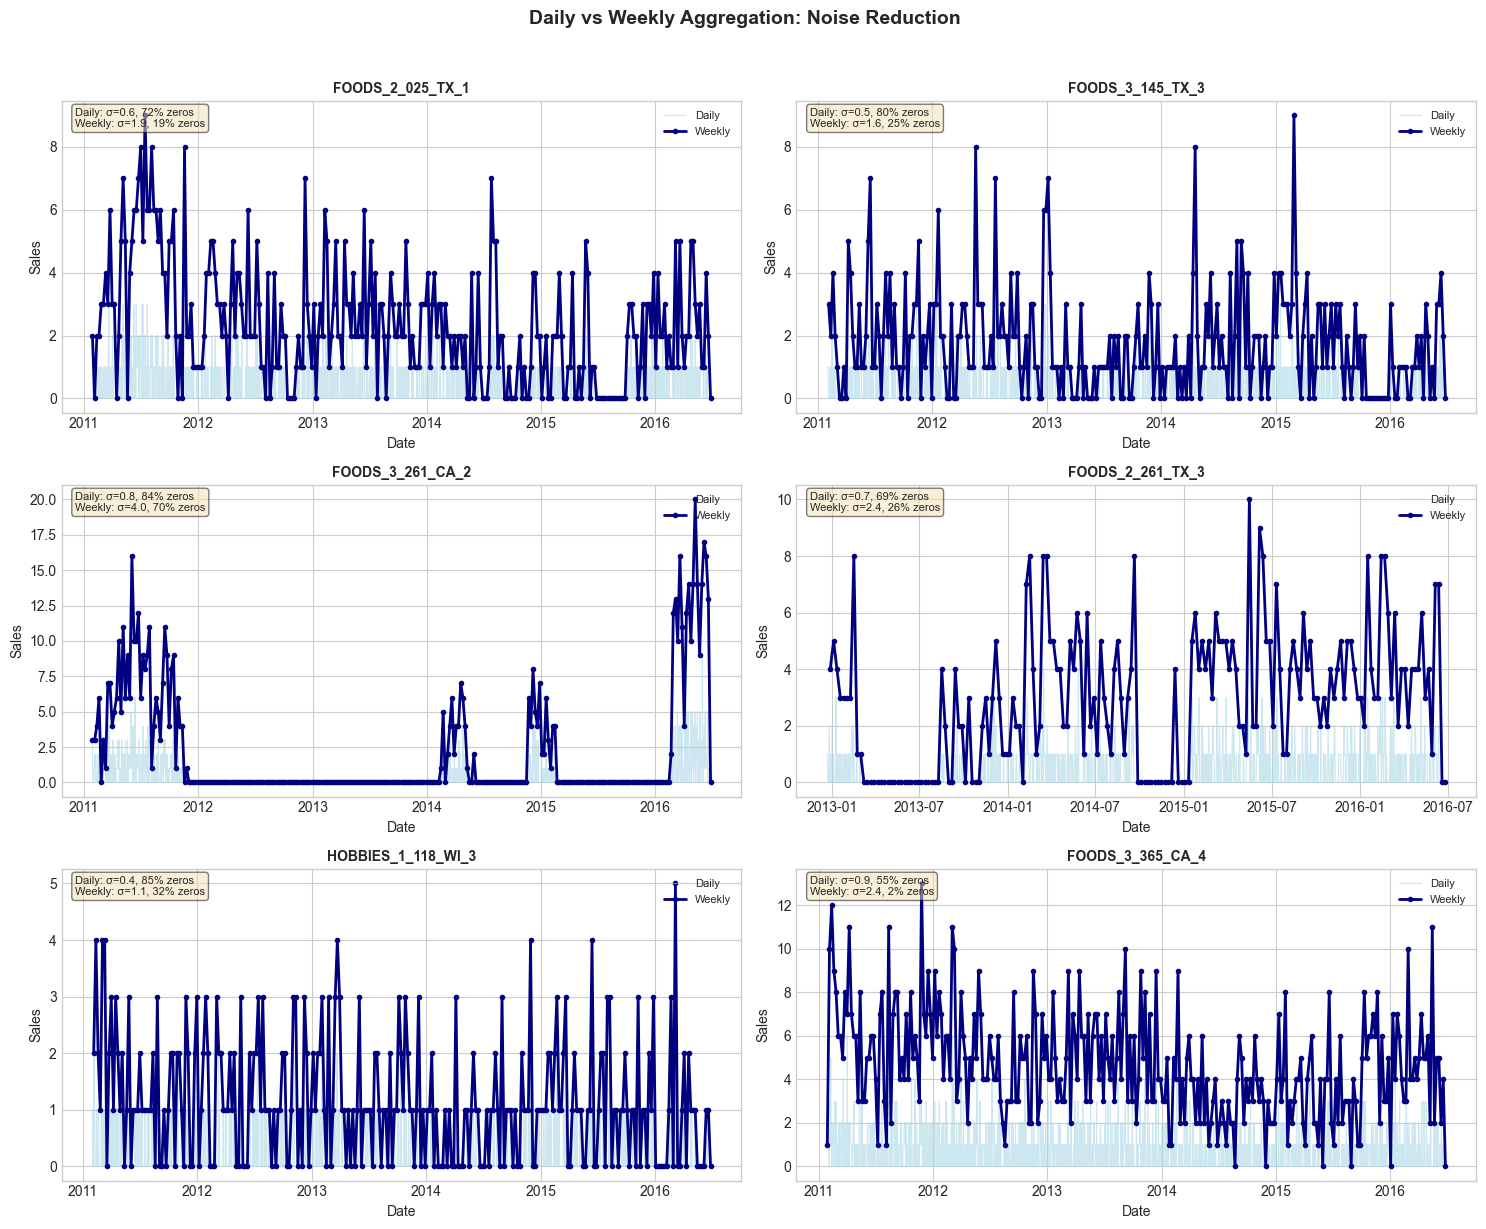


📊 Key Observations:
   • Weekly data shows clearer trends (less day-to-day noise)
   • Seasonality patterns become more visible
   • Fewer zero-sales periods (intermittency reduced)
   • Extreme daily spikes are smoothed into weekly totals


In [ ]:
# Select a few sample series for visualization
sample_ids = y_daily['unique_id'].drop_duplicates().sample(6, random_state=42).tolist()

plot_grid(sample_ids)

In [8]:
# Verify weekly frequency
sample_id = y_weekly_raw["unique_id"].iloc[0]
sample_series = y_weekly_raw.query("unique_id == @sample_id").sort_values("ds")["ds"]

inferred_freq = pd.infer_freq(sample_series)
print(f"Inferred frequency: {inferred_freq}")
print(f"Expected: W-SAT")

Inferred frequency: W-SAT
Expected: W-SAT


---

## 4. Handling Duplicates

At weekly granularity, we need **exactly one row per `unique_id` × `ds`**.

### 4.1 When Do Duplicates Happen?

Duplicates can appear for several reasons:

| Cause | Example | Best Resolution |
|-------|---------|----------------|
| **ETL errors** | Same row loaded twice | Drop exact duplicates |
| **Merge artifacts** | Multiple matches in a join | Aggregate or dedupe |
| **Source system issues** | Two transactions recorded separately | Sum the values |
| **Data corrections** | Old and new values both present | Keep the latest or flag for review |

### 4.2 Duplicate Detection Strategy

We'll classify duplicates into three types:

1. **Exact duplicates** — Same `y` value, just repeated rows → Drop extras
2. **Small discrepancies** — Values differ by < 10% → Sum (likely split transactions)
3. **Large conflicts** — Values differ by > 10% → Flag for imputation (data quality issue)

### 4.3 Check for Duplicates

In [9]:
# Fast duplicate check
dup_counts = y_weekly_raw.groupby(["unique_id", "ds"]).size()
n_duplicates = (dup_counts > 1).sum()

print(f"Duplicate (unique_id, ds) pairs: {n_duplicates:,}")
print(f"Percentage: {n_duplicates / len(dup_counts) * 100:.4f}%")

if n_duplicates > 0:
    print("\n⚠ Duplicates found! Showing examples:")
    dup_pairs = dup_counts[dup_counts > 1].head(5)
    for (uid, ds), count in dup_pairs.items():
        print(f"  {uid} @ {ds.date()}: {count} rows")
        display(y_weekly_raw[(y_weekly_raw['unique_id'] == uid) & 
                             (y_weekly_raw['ds'] == ds)])
else:
    print("\n✓ No duplicates found - data is clean at weekly level")

Duplicate (unique_id, ds) pairs: 0
Percentage: 0.0000%

✓ No duplicates found - data is clean at weekly level


### 4.4 Duplicate Resolution Function

Even if our data is clean, we implement this for production pipelines where duplicates may occur.

In [ ]:
y_weekly_deduped = tsf.resolve_duplicates(y_weekly_raw)
print(f"\nAfter deduplication: {len(y_weekly_deduped):,} rows")
y_weekly_deduped.head()


After deduplication: 6,848,887 rows


,unique_id,ds,y,snap_CA,snap_TX,snap_WI,event_name_1,event_type_1,wm_yr_wk,sell_price_lag7,month,year,is_dupe_exact,is_dupe_resolved,is_dupe_conflict
0,FOODS_1_001_CA_1,2011-01-29,3.0,0,0,0,None,None,11101,NaN,1,2011,0,0,0
1,FOODS_1_001_CA_1,2011-02-05,9.0,1,1,1,None,None,11101,NaN,1,2011,0,0,0
2,FOODS_1_001_CA_1,2011-02-12,7.0,1,1,1,SuperBowl,Sporting,11102,2.0,2,2011,0,0,0
3,FOODS_1_001_CA_1,2011-02-19,8.0,0,1,1,ValentinesDay,Cultural,11103,2.0,2,2011,0,0,0
4,FOODS_1_001_CA_1,2011-02-26,14.0,0,0,0,PresidentsDay,National,11104,2.0,2,2011,0,0,0


### 4.5 When to Drop vs Aggregate vs Flag

**Decision framework for duplicates:**

```
Are the duplicate values identical?
├── YES → Drop extras (exact duplicates, likely ETL error)
└── NO → How different are they?
    ├── Small difference (<10%) → Sum them (likely split transactions)
    └── Large difference (>10%) → Flag as conflict, send to imputation
```

**Why these choices?**
- **Exact duplicates** are almost always ETL errors — safe to drop
- **Small differences** often indicate legitimate split transactions (e.g., two registers)
- **Large differences** suggest data quality issues — better to impute than guess

---

## 5. Fill Gaps with Nixtla `fill_gaps`

### 5.1 Why Gaps Matter

Models assume **regular time intervals**. Gaps break:
- Lag features (lag-1 is wrong if there's a missing week)
- Rolling windows (incomplete windows give wrong statistics)
- Evaluation metrics (missing actuals can't be scored)

### 5.2 Apply `fill_gaps`

Nixtla's `fill_gaps` ensures every series has a complete weekly sequence:
- Inserts missing timestamps as rows with `y = NaN`
- Maintains consistent frequency across all series
- Keeps data sorted and ready for modeling

In [11]:
# Ensure datetime type
y_weekly_deduped["ds"] = pd.to_datetime(y_weekly_deduped["ds"])

# Apply fill_gaps
print("Applying fill_gaps to enforce regular weekly sequence...")

y_weekly_filled = fill_gaps(
    df=y_weekly_deduped,
    freq="W-SAT",
)

y_weekly_filled = y_weekly_filled.sort_values(["unique_id", "ds"]).reset_index(drop=True)

# Flag gaps (rows where y is NaN after fill_gaps)
y_weekly_filled["is_gap"] = y_weekly_filled["y"].isna().astype(int)

n_gaps = y_weekly_filled["is_gap"].sum()
print(f"\nRows before fill_gaps: {len(y_weekly_deduped):,}")
print(f"Rows after fill_gaps: {len(y_weekly_filled):,}")
print(f"Gaps filled: {n_gaps:,} ({n_gaps/len(y_weekly_filled)*100:.2f}%)")

Applying fill_gaps to enforce regular weekly sequence...

Rows before fill_gaps: 6,848,887
Rows after fill_gaps: 6,848,887
Gaps filled: 0 (0.00%)


### ⚠️ 5.3 The Price Gap-Fill Trap

When we have gaps in the data, we'll eventually need to fill them. For the **target variable (`y`)**, forward-fill is usually reasonable.

**But for PRICE, forward-fill is dangerous!**

#### The Problem: Promo Prices Leak Into Non-Promo Weeks

Consider this scenario:

| Week | Price | Status |
|------|-------|--------|
| Week 1 | $10 | Regular |
| Week 2 | $7 | **PROMO** |
| Week 3 | NaN | Missing (item out of stock) |
| Week 4 | NaN | Missing |
| Week 5 | $10 | Regular |

**If we forward-fill price:**

| Week | Price (ffill) | Reality |
|------|---------------|--------|
| Week 3 | $7 ❌ | Would have been $10 (promo ended) |
| Week 4 | $7 ❌ | Would have been $10 |

**The consequence:**
- Model sees weeks 3-4 as "low price" weeks
- When we had sales data for those weeks (if not OOS), it would look like low price = low sales
- This **inverts the expected relationship** and corrupts price elasticity estimates

---

#### Why This Happens in Retail Data

1. **Promotions often precede stockouts** — big promo → sells out → no data
2. **Forward-fill carries the promo price forward** into post-promo periods
3. **The stockout period likely had regular prices** (if there had been inventory)

---

#### Solutions for Price Gaps

| Method | When to Use | Pros | Cons |
|--------|-------------|------|------|
| **Backward fill** | Short gaps after promos | Captures return to regular price | Assumes future is known |
| **Median/Mode fill** | Any gap | Robust to promo spikes | Ignores trends |
| **Interpolate** | Gradual price changes | Smooth transitions | Wrong for step changes |
| **Flag and exclude** | Uncertain gaps | Honest about missing data | Loses observations |
| **Use regular price lookup** | If you have price master | Most accurate | Requires extra data |

**Recommendation:** For M5, `sell_price_lag7` is already at weekly level with few gaps. If gaps exist:
1. First try **backward fill** (better than forward for prices after promos)
2. Or use **median price** for that item-store combination
3. **Never blindly forward-fill prices**

---

#### Key Principle

> **Different variables need different gap-fill strategies.**
> 
> - **Target (y):** Forward-fill is usually fine (demand was likely similar)
> - **Price:** Be very careful — promo prices should NOT propagate forward
> - **Events:** Fill with 0 (no event) is usually correct

### 5.3.1 Check for Price Gaps in Our Data\n\nLet's see if `sell_price_lag7` has any missing values that would require gap-filling.

In [ ]:
tsf.check_price_gaps(df =y_weekly_filled, target='y', price_col='sell_price_lag7')

Price column: sell_price_lag7
Total rows: 6,848,887
Missing prices: 40,537 (0.59%)

⚠ Price Gap Analysis:
  Series with price gaps: 30,382 (99.6%)
  Mean missing per affected series: 1.3
  Max missing in a series: 2

Top 10 series with most price gaps:


,unique_id,total_weeks,missing_prices,pct_missing
0,FOODS_1_001_CA_1,283,2,0.706714
1,FOODS_1_001_CA_2,283,2,0.706714
2,FOODS_1_001_CA_3,283,2,0.706714
11,FOODS_1_002_CA_2,283,2,0.706714
12,FOODS_1_002_CA_3,283,2,0.706714
18,FOODS_1_002_WI_2,283,2,0.706714
21,FOODS_1_003_CA_2,283,2,0.706714
22,FOODS_1_003_CA_3,283,2,0.706714
26,FOODS_1_003_TX_3,283,2,0.706714
27,FOODS_1_003_WI_1,283,2,0.706714


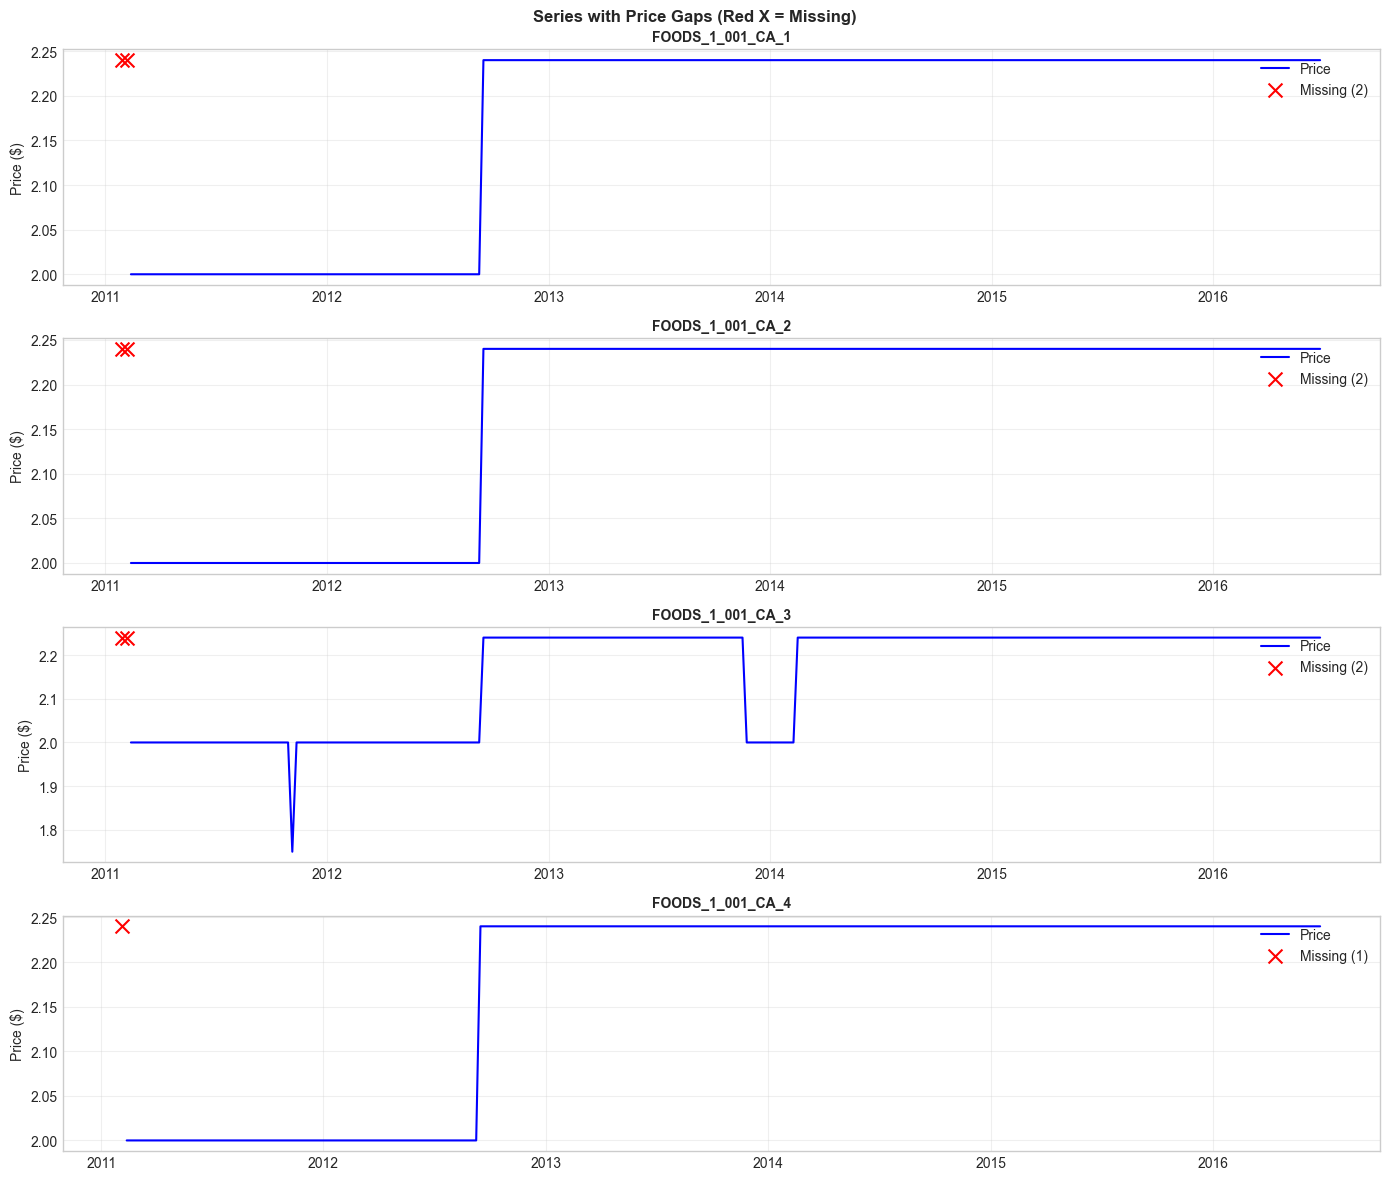


⚠ IMPORTANT: These price gaps need careful handling!
  • Do NOT forward-fill blindly (may propagate promo prices)
  • Consider: backward-fill, median, or flag-and-exclude


In [ ]:
tsf.plot_price_gaps(df =y_weekly_filled, target='y', price_col='sell_price_lag7', sample_size=3)

### 5.3.2 Handle Price Gaps (If Any)\n\nIf we found price gaps, here's how to handle them safely:

In [ ]:
tsf.impute_missing_prices(df =y_weekly_filled, target='y', price_col='sell_price_lag7')

Handling 40,537 missing prices...
✓ Imputed 40,537 prices using per-series median
  Remaining missing: 0
  Flag column added: 'is_price_imputed'


### 5.4 Visualize Gap Distribution

---

## 6. Outlier Detection Methods

Outliers in time series can be:
- **Real events** — promotions, holidays, viral moments (keep these!)
- **Data errors** — wrong decimal place, duplicate counting, system glitches

The challenge: **How do we distinguish signal from noise?**

### 6.1 Three Common Methods

| Method | Formula | Best For | Weakness |
|--------|---------|----------|----------|
| **IQR** | Outside [Q1 - 1.5×IQR, Q3 + 1.5×IQR] | General use, symmetric data | Fails with skewed distributions |
| **Z-Score** | \|x - μ\| / σ > threshold | Normal distributions | Sensitive to outliers themselves |
| **MAD** | \|x - median\| / MAD > threshold | Skewed data, robust | Can be too aggressive |

### 6.2 When to Use Each Method

```
Is your data approximately normal?
├── YES → Z-Score (threshold: 3)
└── NO → Is it heavily skewed (e.g., sales data)?
    ├── YES → MAD (threshold: 5-7)
    └── NO → IQR (multiplier: 1.5-3)
```

**For retail sales data:** We recommend **MAD** because:
- Sales are typically right-skewed
- MAD is robust to the outliers we're trying to detect
- Works well with zero-inflated data

### 6.3 Visual Comparison of Methods

Let's see how each method performs on a sample series.

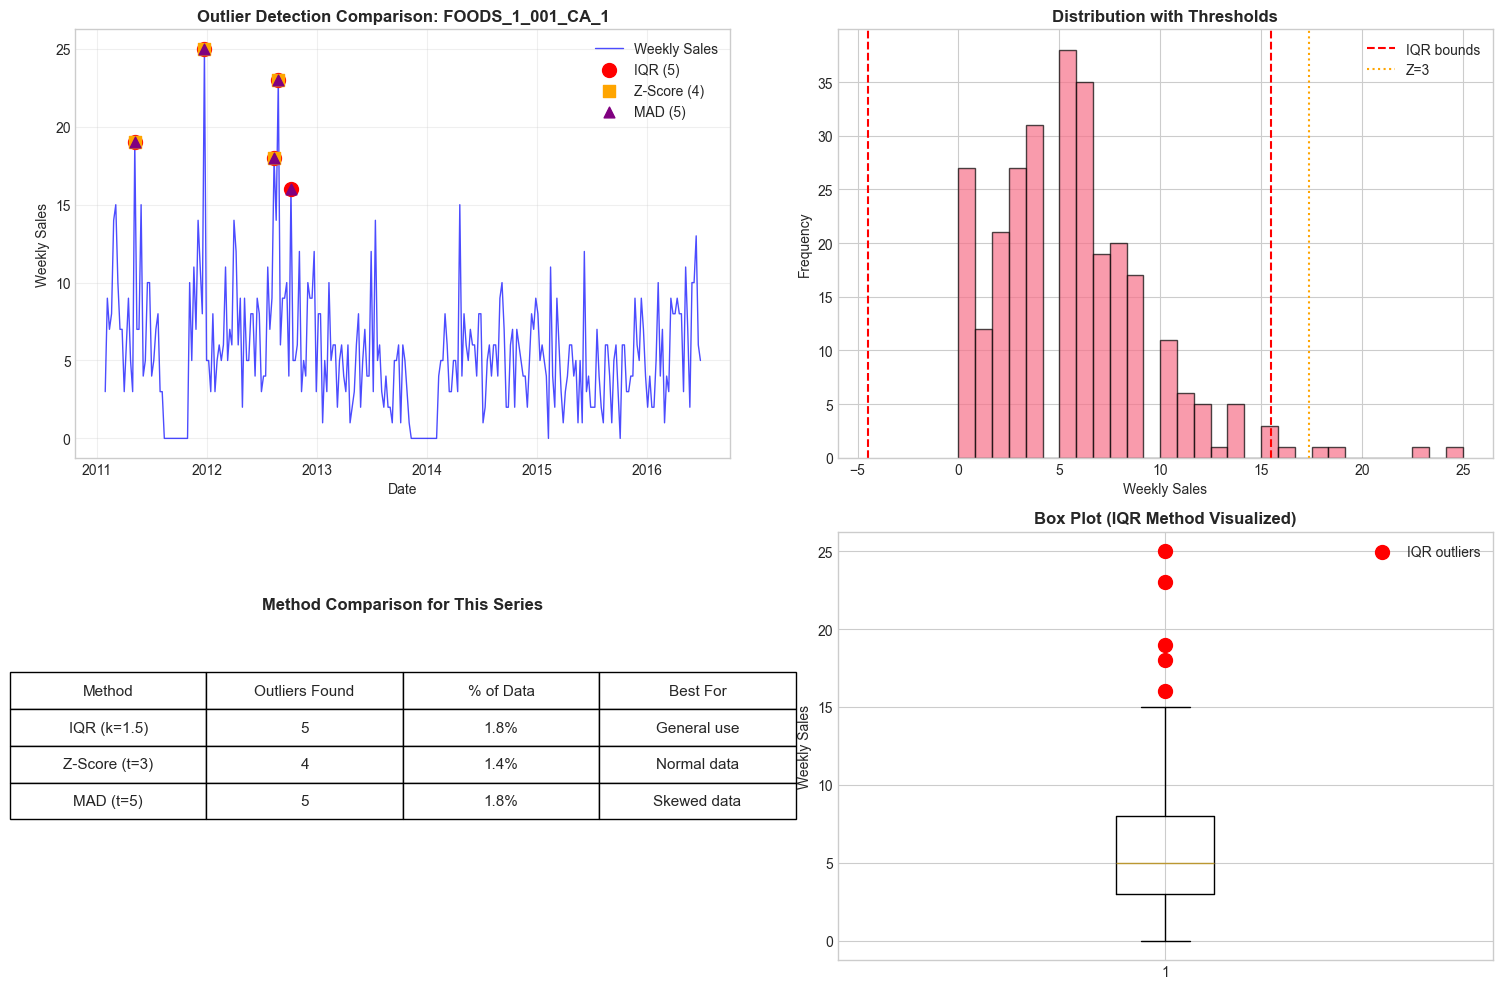


📊 Observation: Different methods flag different points as outliers.
   For skewed sales data, MAD is typically most appropriate.


In [ ]:
# Pick a series with some variation
sample_uid = y_weekly_filled["unique_id"].iloc[0]
sample_data = y_weekly_filled[y_weekly_filled["unique_id"] == sample_uid].copy()
sample_data = sample_data[sample_data["y"].notna()]  # Exclude gaps for outlier detection

# Apply all three methods
sample_data["outlier_iqr"] = tsf.detect_outliers_iqr(sample_data["y"], k=1.5)
sample_data["outlier_zscore"] = tsf.detect_outliers_zscore(sample_data["y"], threshold=3.0)
sample_data["outlier_mad"] = detect_outliers_mad(sample_data["y"], threshold=5.0)

# Visualize
tsf.plot_outliers(sample_data, date_col="ds", value_col="y")

### 6.4 Apply MAD-Based Outlier Detection (Vectorized)

We use a two-threshold approach:
- **Extreme** (threshold=5): Flag for awareness, but keep the value
- **Outlier** (threshold=7): Likely data error, send to imputation

In [ ]:


# Apply outlier detection
print("Detecting outliers using MAD method...")
y_weekly_filled = apply_outlier_flags_vectorized(y_weekly_filled)

n_extreme = y_weekly_filled["is_extreme"].sum()
n_outlier = y_weekly_filled["is_outlier"].sum()

print(f"\nResults:")
print(f"  Extreme values (5 < |z| ≤ 7): {n_extreme - n_outlier:,} (flagged, kept)")
print(f"  Outliers (|z| > 7): {n_outlier:,} (will be imputed)")
print(f"  Total flagged: {n_extreme:,} ({n_extreme/len(y_weekly_filled)*100:.2f}%)")

Detecting outliers using MAD method...

Results:
  Extreme values (5 < |z| ≤ 7): 51,712 (flagged, kept)
  Outliers (|z| > 7): 340,582 (will be imputed)
  Total flagged: 392,294 (5.73%)


### 6.5 Visualize Outlier Distribution Across Portfolio

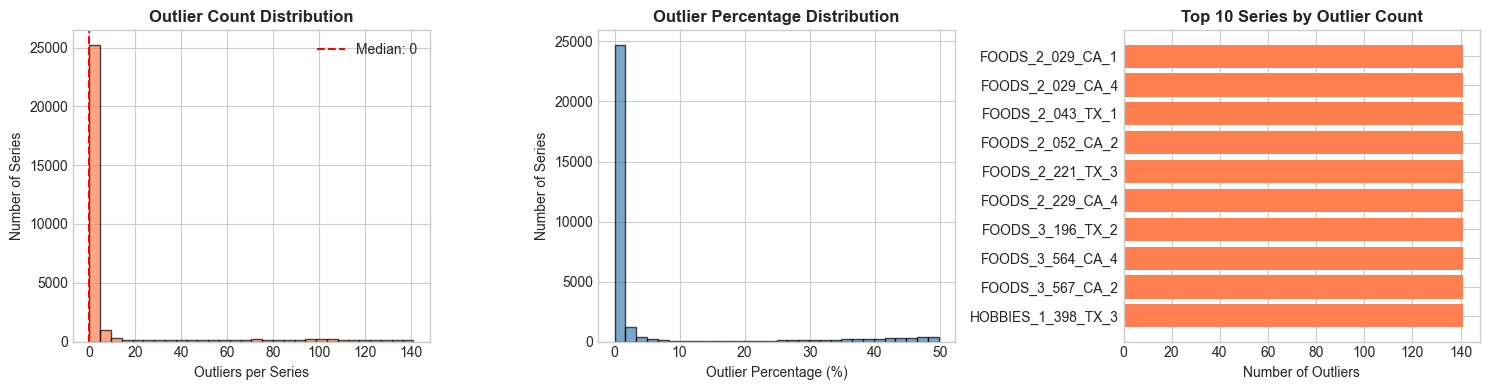

In [ ]:
tsf.plot_outlier_summary(y_weekly_filled)

---

## 7. Unified Imputation Pipeline

### 7.1 What Needs Imputation?

We impute values for:
1. **Gaps** — weeks missing from the original data
2. **Duplicate conflicts** — large discrepancies we couldn't resolve
3. **Severe outliers** — values with |z| > 7 (likely data errors)

In [21]:
# Ensure all flag columns exist
for col in ["is_dupe_conflict"]:
    if col not in y_weekly_filled.columns:
        y_weekly_filled[col] = 0

# Define what needs imputation
y_weekly_filled["needs_imputation"] = (
    (y_weekly_filled["is_gap"] == 1) |
    (y_weekly_filled["is_dupe_conflict"] == 1) |
    (y_weekly_filled["is_outlier"] == 1)
).astype(int)

# Set values needing imputation to NaN
y_weekly_filled.loc[y_weekly_filled["needs_imputation"] == 1, "y_clean"] = np.nan

print(f"Values needing imputation:")
print(f"  From gaps: {y_weekly_filled['is_gap'].sum():,}")
print(f"  From duplicate conflicts: {y_weekly_filled['is_dupe_conflict'].sum():,}")
print(f"  From outliers: {y_weekly_filled['is_outlier'].sum():,}")
print(f"  Total: {y_weekly_filled['needs_imputation'].sum():,}")

Values needing imputation:
  From gaps: 0
  From duplicate conflicts: 0
  From outliers: 340,582
  Total: 340,582


### 7.2 Imputation Strategy

Simple, deterministic, per-series policy:

1. **Forward fill** — use last known value
2. **Backward fill** — for gaps at series start
3. **Zero fill** — only if entire series is missing

In [ ]:
y_weekly_filled = y_weekly_filled.sort_values(["unique_id", "ds"]).reset_index(drop=True)

y_weekly_filled["y_imputed"] = (
    y_weekly_filled
    .groupby("unique_id")["y_clean"]
    .transform(tsf.impute_series)
)

# Final imputation flag
y_weekly_filled["is_imputed"] = y_weekly_filled["needs_imputation"].astype(int)

print(f"✓ Imputation complete")
print(f"  Imputed values: {y_weekly_filled['is_imputed'].sum():,}")
print(f"  Remaining NaN: {y_weekly_filled['y_imputed'].isna().sum()}")

✓ Imputation complete
  Imputed values: 340,582
  Remaining NaN: 0


### 7.3 Visual Before/After Comparison

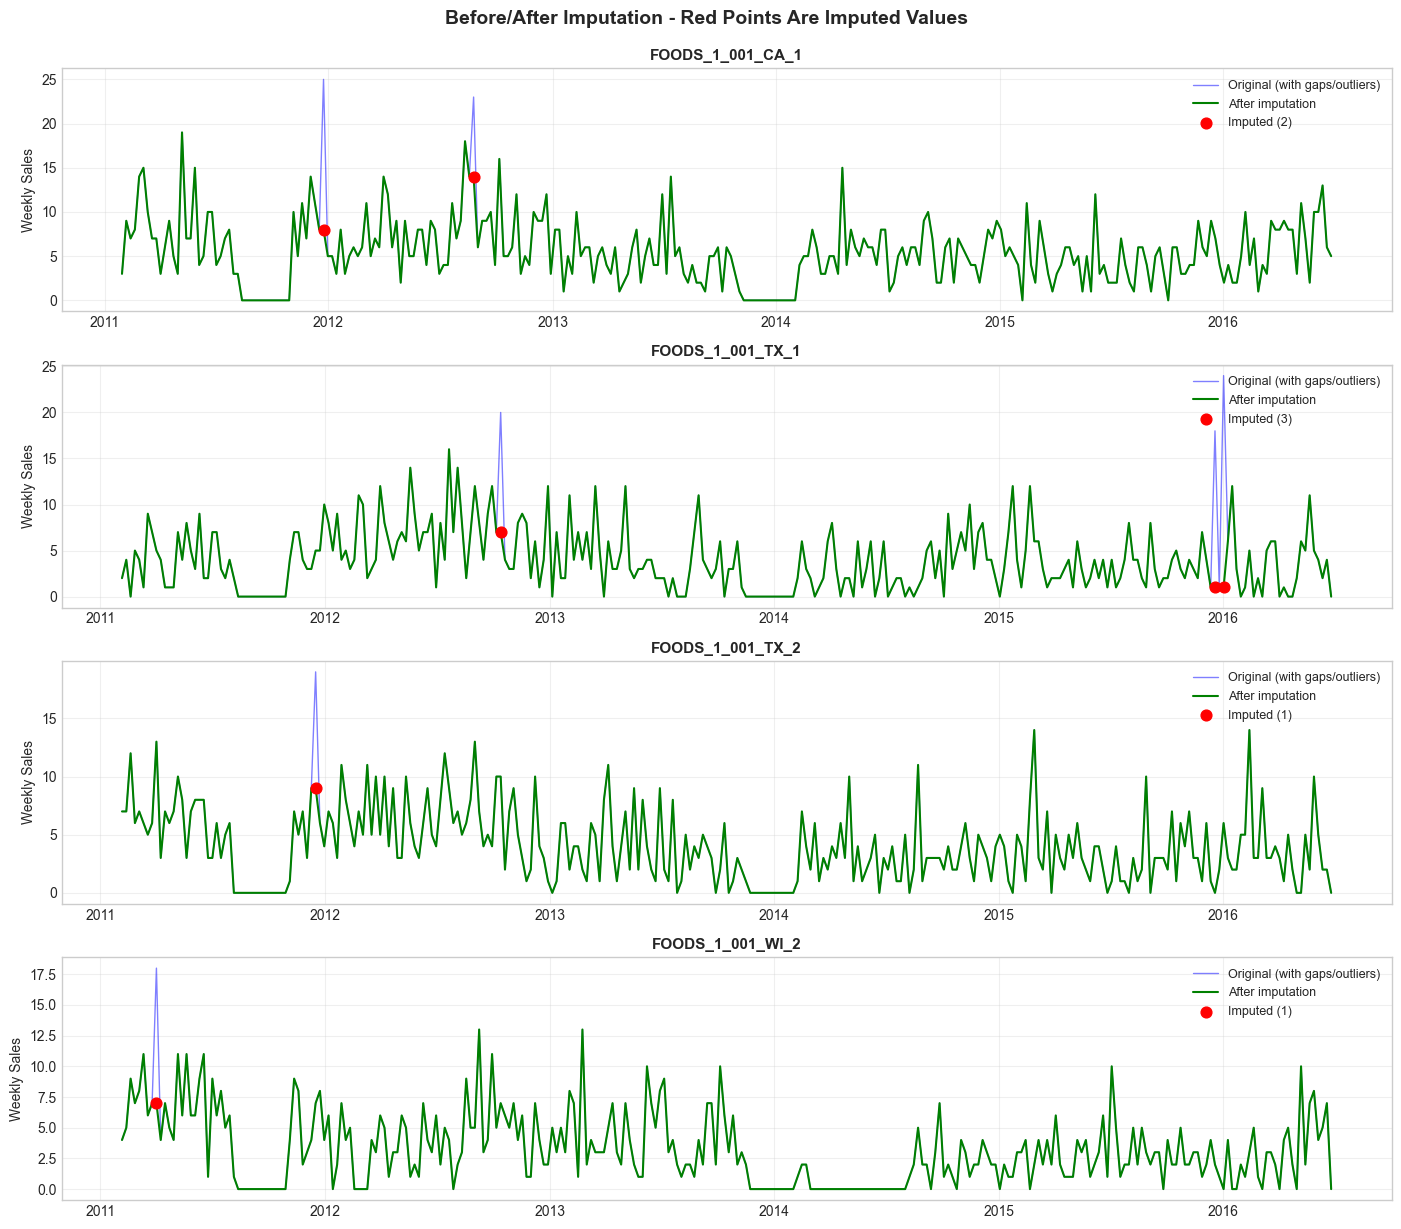

In [ ]:
# Find series with imputed values for visualization
imputed_series = y_weekly_filled[y_weekly_filled["is_imputed"] == 1]["unique_id"].unique()

plot_imputed_series(imputed_series, n_samples=6)

---

## 8. Validation & Quality Checks

In [ ]:
tsf.validation_summary(y_weekly_filled, target_col="y_imputed")

VALIDATION REPORT

1. UNIQUENESS CHECK
   Max rows per (unique_id, ds): 1
   Status: ✓ PASS

2. COMPLETENESS CHECK
   Remaining NaN in y_imputed: 0
   Status: ✓ PASS

3. FREQUENCY CHECK (sample of 5 series)
   FOODS_2_025_TX_1: W-SAT ✓
   FOODS_3_145_TX_3: W-SAT ✓
   FOODS_3_261_CA_2: W-SAT ✓
   FOODS_2_261_TX_3: W-SAT ✓
   HOBBIES_1_118_WI_3: W-SAT ✓

4. DATA SUMMARY
   Total rows: 6,848,887
   Unique series: 30,490
   Date range: 2011-01-29 to 2016-06-25
   Imputed values: 340,582 (4.97%)

✓ VALIDATION COMPLETE


---

## 9. Save Final Output

In [25]:
# Create final output with clean column names
weekly_output = y_weekly_filled[["unique_id", "ds", "y_imputed", "is_imputed"]].copy()
weekly_output = weekly_output.rename(columns={"y_imputed": "y"})

# Save
output_path = OUTPUT_DIR / "m5_weekly_clean.parquet"
weekly_output.to_parquet(output_path, index=False)

print(f"✓ Saved to: {output_path}")
print(f"\nFinal dataset:")
print(f"  Rows: {len(weekly_output):,}")
print(f"  Columns: {list(weekly_output.columns)}")
weekly_output.head()

✓ Saved to: output/m5_weekly_clean.parquet

Final dataset:
  Rows: 6,848,887
  Columns: ['unique_id', 'ds', 'y', 'is_imputed']


,unique_id,ds,y,is_imputed
0,FOODS_1_001_CA_1,2011-01-29,3.0,0
1,FOODS_1_001_CA_1,2011-02-05,9.0,0
2,FOODS_1_001_CA_1,2011-02-12,7.0,0
3,FOODS_1_001_CA_1,2011-02-19,8.0,0
4,FOODS_1_001_CA_1,2011-02-26,14.0,0


---

## 10. Putting It All Together: 5Q Framework

Let's review how our data preparation decisions support the **5Q Framework**:

### **Q1: Target & Decision**
**Decision:** Weekly retail replenishment planning  
**What we did:**
- ✓ Aggregated daily → weekly (sum) to match decision cadence
- ✓ Preserved complete demand signal
- ✓ Treated outliers conservatively (only severe errors, not promotions)

---

### **Q2: Metrics**
**Metrics:** MAE, RMSE, WAPE  
**What we did:**
- ✓ Ensured complete time sequences (no gaps that break evaluation)
- ✓ Flagged imputed values for potential filtering in CV
- ✓ Maintained consistent weekly frequency across all series

---

### **Q3: Horizon & Level**
**Horizon:** Rolling 4-13 week forecasts  
**Level:** Item-store (SKU) level  
**What we did:**
- ✓ Weekly granularity supports multi-week horizons
- ✓ Used `fill_gaps` to ensure regular time intervals for lag features
- ✓ Classified gap runs to identify problematic series

---

### **Q4: Data & Drivers**
**Data:** Sales history  
**Drivers:** Seasonality, promotions, holidays  
**What we did:**
- ✓ Preserved promotional spikes (not treated as outliers)
- ✓ Used MAD for outlier detection (robust to sales skewness)
- ✓ Two-threshold approach: extreme (flag) vs severe (impute)

---

### **Q5: Ownership & Stability**
**Ownership:** Data science team  
**Stability:** Weekly refresh  
**What we did:**
- ✓ Transparent flagging (`is_imputed`) for auditability
- ✓ Deterministic pipeline (same input → same output)
- ✓ Documented all policies (duplicates, gaps, outliers)

---

### **Key Takeaway**

Every data preparation decision traces back to supporting the business decision:

- *"We use weekly granularity because replenishment planning is weekly."*
- *"We flag imputed values so models can weight them appropriately."*
- *"We use MAD for outliers because sales data is skewed."*
- *"We keep extreme values unless they're obvious errors, because promotions matter."*

---

## 11. Summary

In this module, we:

1. **Converted to weekly granularity** using `freq="W-SAT"` to align with M5 weeks

2. **Handled duplicates** with a clear framework:
   - Exact duplicates → drop
   - Small discrepancies → sum
   - Large conflicts → impute

3. **Filled gaps** using Nixtla's `fill_gaps`:
   - Regular weekly sequences for all series
   - Classified short vs long gaps

4. **Detected outliers** with multiple methods:
   - IQR, Z-score, MAD — when to use each
   - Two-threshold approach: extreme (keep) vs severe (impute)
   - Vectorized implementation for speed

5. **Applied transparent imputation**:
   - Forward fill → backward fill → zero
   - `is_imputed` flag for model awareness

---

## What's Next?

**Module 1.10 - Plotting Your Data:**
- Visual EDA with TSForge plotting utilities
- Identify trends, seasonality, and anomalies

**Module 1.11 - Reading the Patterns:**
- Translate visual patterns into modeling decisions
- Segment series by behavior